# Imports

In [1]:
import os
os.chdir('/DeepPurpose/')

import DeepPurpose.DTI as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *
import random
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np

In [2]:
# load_process_DAVIS()

In [3]:
# download_BindingDB()

In [25]:
X_drug, X_target, y  = process_BindingDB('/home/sars-busters-consolidated/data/BindingDB_All.tsv',
                                         y = 'Kd', 
                                         binary = True, ## Keep it binary true for classification task
                                         convert_to_log = True)

Loading Dataset from path...


b'Skipping line 896772: expected 193 fields, saw 205\nSkipping line 896798: expected 193 fields, saw 205\n'
b'Skipping line 929491: expected 193 fields, saw 205\n'
b'Skipping line 952161: expected 193 fields, saw 265\n'
b'Skipping line 1355895: expected 193 fields, saw 241\n'
b'Skipping line 1469800: expected 193 fields, saw 241\nSkipping line 1469801: expected 193 fields, saw 241\nSkipping line 1469802: expected 193 fields, saw 241\nSkipping line 1469803: expected 193 fields, saw 241\nSkipping line 1469804: expected 193 fields, saw 241\nSkipping line 1469805: expected 193 fields, saw 241\nSkipping line 1469806: expected 193 fields, saw 241\nSkipping line 1469807: expected 193 fields, saw 241\nSkipping line 1469808: expected 193 fields, saw 241\n'
b'Skipping line 1483073: expected 193 fields, saw 205\n'
b'Skipping line 1502296: expected 193 fields, saw 241\nSkipping line 1502297: expected 193 fields, saw 241\nSkipping line 1502298: expected 193 fields, saw 241\nSkipping line 1502299: e

Beginning Processing...
There are 70750 drug target pairs.
Default binary threshold for the binding affinity scores are 30, you can adjust it by using the "threshold" parameter


# Original DeepPurpose

In [5]:
drug_encoding = 'Transformer'
target_encoding = 'CNN'

all_data, nil1, nil2 = data_process(X_drug, 
                                X_target, 
                                y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[1.0,0.0,0.0])

config = generate_config(drug_encoding = drug_encoding, 
                         target_encoding = target_encoding, 
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 100, 
                         LR = 0.001, 
                         batch_size = 128,
                         cnn_target_filters = [32,64,96],
                         cnn_target_kernels = [4,8,12]
                        )

Drug Target Interaction Prediction Mode...
in total: 70750 drug-target pairs
encoding drug...
unique drugs: 13392
encoding protein...
unique target sequence: 1507
splitting dataset...
Done.


In [6]:
shuffled = all_data.sample(frac=1)
result = np.array_split(shuffled, 10)  

train = pd.concat(result[0:7]).reset_index()
val = pd.concat([result[7]]).reset_index()
test = pd.concat(result[8:10]).reset_index()

In [41]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [7]:
train.shape

(49525, 6)

In [8]:
test.shape

(14150, 6)

Let's use 4 GPUs!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69518. Total time 0.00361 hours
Training at Epoch 1 iteration 100 with loss 0.34904. Total time 0.01722 hours
Training at Epoch 1 iteration 200 with loss 0.30562. Total time 0.03305 hours
Training at Epoch 1 iteration 300 with loss 0.29947. Total time 0.04916 hours
Validation at Epoch 1, AUROC: 0.83298 , AUPRC: 0.59041 , F1: 0.24198 , Cross-entropy Loss: 5.07707
Training at Epoch 2 iteration 0 with loss 0.27694. Total time 0.06833 hours
Training at Epoch 2 iteration 100 with loss 0.31445. Total time 0.08388 hours
Training at Epoch 2 iteration 200 with loss 0.31005. Total time 0.10027 hours
Training at Epoch 2 iteration 300 with loss 0.38071. Total time 0.11638 hours
Validation at Epoch 2, AUROC: 0.83880 , AUPRC: 0.61062 , F1: 0.45139 , Cross-entropy Loss: 4.71096
Training at Epoch 3 iteration 0 with loss 0.30282. Total time 0.13583 hours
Training at Epoch 3 iteration 100 with 

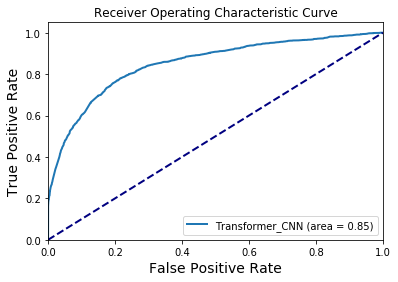

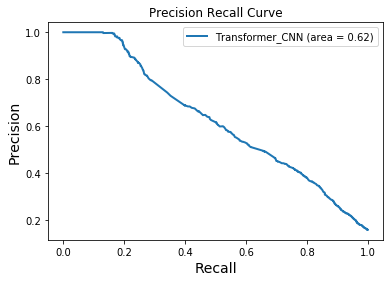

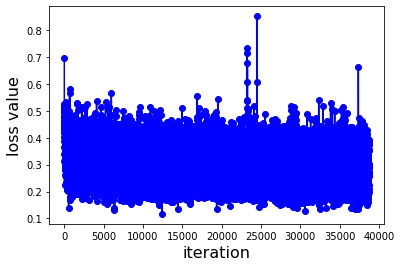

In [9]:
model = models.model_initialize(**config)
model.train(train, val, test)

In [10]:
model.save_model('/home/sars-busters-consolidated/deep_purpose/save_folder/pretrained_model/transformer_CNN_fold5')

In [11]:
test_preidcted = model.predict(test)
test['Y_predicted'] = test_preidcted

predicting...


In [12]:
train.to_csv('../data/Transformer_CNN_train_fold5.csv')
val.to_csv('../data/Transformer_CNN_val_fold5.csv')
test.to_csv('../data/Transformer_CNN_test_fold5.csv')

# Preparing Degree Lists for Original DeepPurpose Data

In [2]:
train = pd.read_csv('../data/Transformer_CNN_train_fold5.csv')
val = pd.read_csv('../data/Transformer_CNN_val_fold5.csv')
test = pd.read_csv('../data/Transformer_CNN_test_fold5.csv')

In [3]:
ligands = list(set(train['SMILES'].tolist()))
targets = list(set(train['Target Sequence'].tolist()))

number_ligands = len(ligands)
number_targets = len(targets)
print('Ligands: ', number_ligands)
print('Targets: ',number_targets)

Ligands:  10410
Targets:  1404


In [4]:
ligands_degree_dict = dict()

for smile_chem in tqdm(ligands):
    sum_df = train[train['SMILES'] == smile_chem]
    ligands_degree_dict[smile_chem] = dict()
    ligands_degree_dict[smile_chem]['deg_0'] = len(sum_df[sum_df['Label'] == 0])
    ligands_degree_dict[smile_chem]['deg_1'] = len(sum_df[sum_df['Label'] == 1])
    
targets_degree_dict = dict()

for aa_target in tqdm(targets):
    sum_df = train[train['Target Sequence'] == aa_target]
    targets_degree_dict[aa_target] = dict()
    targets_degree_dict[aa_target]['deg_0'] = len(sum_df[sum_df['Label'] == 0])
    targets_degree_dict[aa_target]['deg_1'] = len(sum_df[sum_df['Label'] == 1])
    
degree_train_1_0_ligands = [ligands_degree_dict[key_val]['deg_1'] for key_val in tqdm(ligands_degree_dict.keys())]
degree_train_0_1_ligands = [ligands_degree_dict[key_val]['deg_0'] for key_val in tqdm(ligands_degree_dict.keys())]

degree_train_1_0_targets = [targets_degree_dict[key_val]['deg_1'] for key_val in tqdm(targets_degree_dict.keys())]
degree_train_0_1_targets = [targets_degree_dict[key_val]['deg_0'] for key_val in tqdm(targets_degree_dict.keys())]

100%|██████████| 1404/1404 [00:00<00:00, 1188456.67it/s]


In [5]:
with open('../data/fold5/degreetrain10ligands.txt', 'w') as file:
    for degree in degree_train_1_0_ligands:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/fold5/degreetrain01ligands.txt', 'w') as file:
    for degree in degree_train_0_1_ligands:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/fold5/degreetrain10targets.txt', 'w') as file:
    for degree in degree_train_1_0_targets:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/fold5/degreetrain01targets.txt', 'w') as file:
    for degree in degree_train_0_1_targets:
        file.write("%i\n" % degree)
        
file.close()

textfile = open("../data/fold5/ligands.txt", "w")
for element in ligands:
    textfile.write(element + "\n")
textfile.close()

textfile = open("../data/fold5/targets.txt", "w")
for element in targets:
    textfile.write(element + "\n")
textfile.close()

# Randomly assigning SMILEs and Sequences

In [26]:
def swapper(intake_list):
    
    swap_dict = {}
    bag = set(intake_list)
    buffer = set()
    
    for item in set(intake_list):
        
        if len(bag) > 0:
            #selected = bag.pop()
            selected = random.choice(list(bag))
            bag.remove(selected)
        else:
            selected = random.choice(list(buffer))
            buffer.remove(selected)
        
        if item != selected:
            swap_dict.update({item:selected})
        else:
            print(f'Same item selected item {item} selected {selected}')
            buffer.add(selected)
    
    assert len(bag) == 0, bag
    
    return swap_dict
            

In [27]:
fake_X_drug_mapping = swapper(list(X_drug))

In [36]:
fake_X_target_mapping = swapper(list(X_target))

In [37]:
correct_dataset = pd.DataFrame({'X_drug': X_drug, 'X_target': X_target, 'y': y})

In [38]:
correct_dataset['fake_X_drug'] = correct_dataset['X_drug'].map(fake_X_drug_mapping)
correct_dataset['fake_X_target'] = correct_dataset['X_target'].map(fake_X_target_mapping)

In [39]:
for column in correct_dataset.columns:
    print(correct_dataset[correct_dataset[column].isna()])

Empty DataFrame
Columns: [X_drug, X_target, y, fake_X_drug, fake_X_target]
Index: []
Empty DataFrame
Columns: [X_drug, X_target, y, fake_X_drug, fake_X_target]
Index: []
Empty DataFrame
Columns: [X_drug, X_target, y, fake_X_drug, fake_X_target]
Index: []
Empty DataFrame
Columns: [X_drug, X_target, y, fake_X_drug, fake_X_target]
Index: []
Empty DataFrame
Columns: [X_drug, X_target, y, fake_X_drug, fake_X_target]
Index: []


In [40]:
correct_dataset = correct_dataset[~correct_dataset['fake_X_drug'].isna()]

In [41]:
drug_encoding = 'Transformer'
target_encoding = 'CNN'
train_shuffled, val_shuffled, test_shuffled = data_process(list(correct_dataset['fake_X_drug']), 
                                list(correct_dataset['fake_X_target']), 
                                y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[0.7,0.1,0.2])

config = generate_config(drug_encoding = drug_encoding, 
                         target_encoding = target_encoding, 
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 100, 
                         LR = 0.001, 
                         batch_size = 128,
                         cnn_target_filters = [32,64,96],
                         cnn_target_kernels = [4,8,12]
                        )

Drug Target Interaction Prediction Mode...
in total: 70750 drug-target pairs
encoding drug...
unique drugs: 13392
encoding protein...
unique target sequence: 1507
splitting dataset...
Done.


Let's use 4 GPUs!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69468. Total time 0.00611 hours
Training at Epoch 1 iteration 100 with loss 0.38348. Total time 0.02527 hours
Training at Epoch 1 iteration 200 with loss 0.35854. Total time 0.04472 hours
Training at Epoch 1 iteration 300 with loss 0.42957. Total time 0.06361 hours
Validation at Epoch 1, AUROC: 0.81083 , AUPRC: 0.51491 , F1: 0.38037 , Cross-entropy Loss: 4.99410
Training at Epoch 2 iteration 0 with loss 0.33293. Total time 0.08722 hours
Training at Epoch 2 iteration 100 with loss 0.30806. Total time 0.10611 hours
Training at Epoch 2 iteration 200 with loss 0.34547. Total time 0.12583 hours
Training at Epoch 2 iteration 300 with loss 0.34002. Total time 0.14472 hours
Validation at Epoch 2, AUROC: 0.81402 , AUPRC: 0.54364 , F1: 0.23394 , Cross-entropy Loss: 4.89156
Training at Epoch 3 iteration 0 with loss 0.43026. Total time 0.16861 hours
Training at Epoch 3 iteration 100 with 

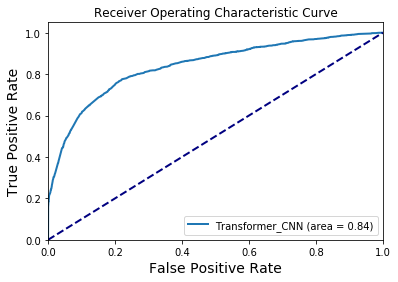

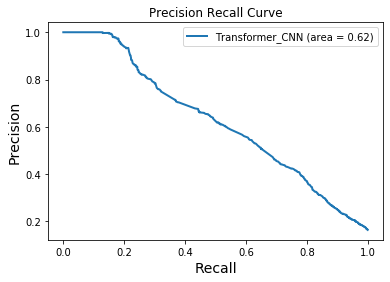

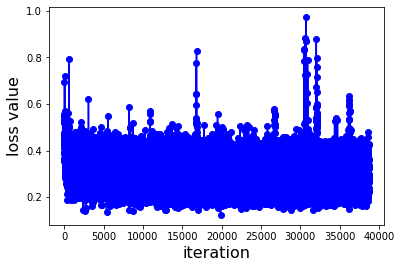

In [42]:
model_shuffled = models.model_initialize(**config)
model_shuffled.train(train_shuffled, val_shuffled, test_shuffled)

# Performances for Unseen Edges, Unseen Targets and Unseen Nodes

In [6]:
train_ligands = list(set(train['SMILES'].tolist()))
train_targets = list(set(train['Target Sequence'].tolist()))

test_minus_train_ligands = list(set(test['SMILES'].tolist()).difference(train_ligands))
test_minus_train_targets = list(set(test['Target Sequence'].tolist()).difference(train_targets))

In [7]:
print('Seen ligands: ', len(train_ligands))
print('Seen targets: ', len(train_targets))
print('Unseen ligands: ', len(test_minus_train_ligands))
print('Unseen targets: ', len(test_minus_train_targets))

Seen ligands:  10410
Seen targets:  1404
Unseen ligands:  2028
Unseen targets:  73


In [8]:
# Unseen Edges

test_unseen_edges = test[test['SMILES'].isin(train_ligands) & test['Target Sequence'].isin(train_targets)]
print('Unseen edges: ', len(test_unseen_edges))

print('AUC: ', roc_auc_score(test_unseen_edges['Label'].tolist(), test_unseen_edges['Y_predicted']))
print('AUP: ', average_precision_score(test_unseen_edges['Label'].tolist(), test_unseen_edges['Y_predicted']))

Unseen edges:  11923
AUC:  0.8185677164986843
AUP:  0.4761129506555852


In [9]:
# Unseen Targets

test_unseen_targets = test[test['Target Sequence'].isin(test_minus_train_targets)]
print('Unseen targets: ', len(test_unseen_targets))

print('AUC: ', roc_auc_score(test_unseen_targets['Label'].tolist(), test_unseen_targets['Y_predicted']))
print('AUP: ', average_precision_score(test_unseen_targets['Label'].tolist(), test_unseen_targets['Y_predicted']))

Unseen targets:  81
AUC:  0.7448830409356725
AUP:  0.6517717452558452


In [22]:
# Unseen Nodes

test_unseen_nodes = test[test['SMILES'].isin(test_minus_train_ligands) & test['Target Sequence'].isin(test_minus_train_targets)]
print('Unseen nodes: ', len(test_unseen_nodes))

print('AUC: ', roc_auc_score(test_unseen_nodes['Label'].tolist(), test_unseen_nodes['Y_predicted']))
print('AUP: ', average_precision_score(test_unseen_nodes['Label'].tolist(), test_unseen_nodes['Y_predicted']))

Unseen nodes:  37
AUC:  0.6433333333333333
AUP:  0.44722220144334984


In [23]:
NDM = pd.read_csv('../data/NDM_Master.csv')

# Unseen Nodes - Natural Ligands

test_unseen_nodes = test[test['SMILES'].isin(test_minus_train_ligands) & test['SMILES'].isin(NDM['SMILE'].tolist()) & test['Target Sequence'].isin(test_minus_train_targets)]
print('Unseen nodes: ', len(test_unseen_nodes))

print('AUC: ', roc_auc_score(test_unseen_nodes['Label'].tolist(), test_unseen_nodes['Y_predicted']))
print('AUP: ', average_precision_score(test_unseen_nodes['Label'].tolist(), test_unseen_nodes['Y_predicted']))

/miniconda/envs/DeepPurpose/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8,20,21,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unseen nodes:  0


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [11]:
train_pos = train[train['Label'] == 1]
train_neg = train[train['Label'] == 0]

ligands_1 = set(train_pos['SMILES'].tolist())
ligands_0 = set(train_neg['SMILES'].tolist())
targets_1 = set(train_pos['Target Sequence'].tolist())
targets_0 = set(train_neg['Target Sequence'].tolist())

print('Total ligands: ', len(list(set(train['SMILES'].tolist()))))
print('Total targets: ', len(list(set(train['Target Sequence'].tolist()))))
print('Ligands with only positive: ', len(list(ligands_1.difference(ligands_0))))
print('Targets with only positive: ', len(list(targets_1.difference(targets_0))))
print('Ligands with only negative: ', len(list(ligands_0.difference(ligands_1))))
print('Targets with only negative: ', len(list(targets_0.difference(targets_1))))

Total ligands:  10410
Total targets:  1404
Ligands with only positive:  3094
Targets with only positive:  170
Ligands with only negative:  6539
Targets with only negative:  560


# Duplex Configuration Model

In [12]:
train_pos = train[train['Label'] == 1]
train_neg = train[train['Label'] == 0]

In [13]:
pos_deg_0_ligands = []
pos_deg_0_targets = []
neg_deg_0_ligands = []
neg_deg_0_targets = []

ligand_degree_ratio = dict()
ligand_all_average = []

for ligand in tqdm(ligands):
    pos_deg = len(train_pos[train_pos['SMILES'] == ligand])
    neg_deg = len(train_neg[train_neg['SMILES'] == ligand])
    ligand_degree_ratio[ligand] = dict()
    ligand_degree_ratio[ligand]['deg_ratio'] = pos_deg / (pos_deg + neg_deg)
    ligand_degree_ratio[ligand]['deg_avg'] = pos_deg / number_targets 
    ligand_all_average.append(pos_deg / number_targets)
    if pos_deg == 0:
        pos_deg_0_ligands.append(ligand)
    if neg_deg == 0:
        neg_deg_0_ligands.append(ligand)
    
ligands_all_avg = sum(ligand_all_average) / number_ligands

targets_degree_ratio = dict()
target_all_average = []

for target in tqdm(targets):
    pos_deg = len(train_pos[train_pos['Target Sequence'] == target])
    neg_deg = len(train_neg[train_neg['Target Sequence'] == target])
    targets_degree_ratio[target] = dict()
    targets_degree_ratio[target]['deg_ratio'] = pos_deg / (pos_deg + neg_deg)
    targets_degree_ratio[target]['deg_avg'] = pos_deg / number_ligands
    target_all_average.append(pos_deg / number_ligands)
    if pos_deg == 0:
        pos_deg_0_targets.append(target)
    if neg_deg == 0:
        neg_deg_0_targets.append(target)
    
targets_all_avg = sum(target_all_average) / number_targets

print('Ligands with positive degree 0: ',len(pos_deg_0_ligands))
print('Ligands with negative degree 0: ',len(neg_deg_0_ligands))
print('Targets with positive degree 0: ',len(pos_deg_0_targets))
print('Targets with negative degree 0: ',len(neg_deg_0_targets))

100%|██████████| 1404/1404 [00:09<00:00, 153.39it/s]

Ligands with positive degree 0:  6539
Ligands with negative degree 0:  3094
Targets with positive degree 0:  560
Targets with negative degree 0:  170


In [14]:
## Annotated means the node has at least 1 binding information

pos_annotated_ligands = list(set(ligands)-set(pos_deg_0_ligands))
pos_annotated_targets = list(set(targets)-set(pos_deg_0_targets))

neg_annotated_ligands = list(set(ligands)-set(neg_deg_0_ligands))
neg_annotated_targets = list(set(targets)-set(neg_deg_0_targets))

In [15]:
summat10 = np.loadtxt(open("../data/fold5/summat10.csv", "rb"), delimiter=",", skiprows=0) # Output of MATLAB run 
summat01 = np.loadtxt(open("../data/fold5/summat01.csv", "rb"), delimiter=",", skiprows=0) # Output of MATLAB run 

In [16]:
test_probabilty_predicted_conditioned = []

## Average conditional probability
p10_avg = np.mean(summat10)
p01_avg = np.mean(summat01)
average_conditional_probability = p10_avg / (p10_avg + p01_avg)

for index, row in tqdm(test.iterrows()):      
    
    if row['SMILES'] in pos_annotated_ligands and row['Target Sequence'] in pos_annotated_targets:
        p10 = summat10[ligands.index(row['SMILES']),targets.index(row['Target Sequence'])]
        p01 = summat01[ligands.index(row['SMILES']),targets.index(row['Target Sequence'])]
        p10_conditioned = p10 / (p10 + p01)
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        
    elif row['SMILES'] in pos_annotated_ligands and row['Target Sequence'] not in pos_annotated_targets:
        p10_conditioned = ligand_degree_ratio[row['SMILES']]['deg_ratio']  ## k_+ / (k_+ + k_-)
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        
    elif row['SMILES'] not in pos_annotated_ligands and row['Target Sequence'] in pos_annotated_targets:
        p10_conditioned = targets_degree_ratio[row['Target Sequence']]['deg_ratio'] ## k_+ / (k_+ + k_-)
        test_probabilty_predicted_conditioned.append(p10_conditioned)

    else:
        p10_conditioned = average_conditional_probability
        test_probabilty_predicted_conditioned.append(p10_conditioned)
        

14150it [00:05, 2439.04it/s]


In [17]:
## Performance on the test dataset

print('AUC: ', roc_auc_score(test['Label'].tolist(), test_probabilty_predicted_conditioned))
print('AUP: ', average_precision_score(test['Label'].tolist(), test_probabilty_predicted_conditioned))

AUC:  0.8582543754488434
AUP:  0.6110111695033403


In [18]:
test['duplex_config_prediction'] = test_probabilty_predicted_conditioned

In [24]:
# Unseen Edges

test_unseen_edges = test[test['SMILES'].isin(train_ligands) & test['Target Sequence'].isin(train_targets)]
print('Unseen edges: ', len(test_unseen_edges))

print('AUC: ', roc_auc_score(test_unseen_edges['Label'].tolist(), test_unseen_edges['duplex_config_prediction']))
print('AUP: ', average_precision_score(test_unseen_edges['Label'].tolist(), test_unseen_edges['duplex_config_prediction']))

Unseen edges:  11923
AUC:  0.8424130228864826
AUP:  0.49891624652412536


In [20]:
# Unseen Targets

test_unseen_targets = test[test['Target Sequence'].isin(test_minus_train_targets)]
print('Unseen targets: ', len(test_unseen_targets))

print('AUC: ', roc_auc_score(test_unseen_targets['Label'].tolist(), test_unseen_targets['duplex_config_prediction']))
print('AUP: ', average_precision_score(test_unseen_targets['Label'].tolist(), test_unseen_targets['duplex_config_prediction']))

Unseen targets:  81
AUC:  0.7178362573099416
AUP:  0.6301376005739763


In [21]:
# Unseen Nodes

test_unseen_nodes = test[test['SMILES'].isin(test_minus_train_ligands) & test['Target Sequence'].isin(test_minus_train_targets)]
print('Unseen nodes: ', len(test_unseen_nodes))

print('AUC: ', roc_auc_score(test_unseen_nodes['Label'].tolist(), test_unseen_nodes['duplex_config_prediction']))
print('AUP: ', average_precision_score(test_unseen_nodes['Label'].tolist(), test_unseen_nodes['duplex_config_prediction']))

Unseen nodes:  37
AUC:  0.5
AUP:  0.32432432432432434
